In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
from sympy import Matrix, tanh, exp
from sympy.abc import x, y
from sympy import symbols
#from utils import newtons_method
from smt.sampling_methods import LHS
import random
import math

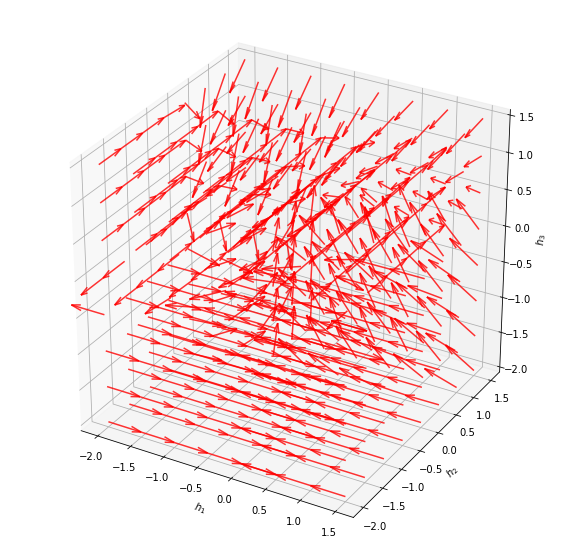

In [178]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')


N = 3
#W = np.random.normal(0, 1/N, size=(N, N))
#J = np.random.normal(0, 1/N, size=(N, N))

h1 = np.arange(-2, 2, 0.5)
h2 = np.arange(-2, 2, 0.5)
h3 = np.arange(-2, 2, 0.5)
h1_h2_h3 = list(itertools.product(h1,h2,h3))


#vectorize arc function
alpha = 10*6
arc = lambda x: ((2/math.pi)*math.atan(x))/(1 + np.exp(-alpha * x))
arc_func = np.vectorize(arc)


#vectorize tanh nonlinearity
gain = 10
tanh = lambda x: np.tanh(gain*x)
tanh_func = np.vectorize(tanh)

for i in h1_h2_h3: 

    h = np.array(i)
    dh_dt = np.multiply(arc_func(W @ h), -h + J@tanh_func(h))
    
    
    ax.quiver(i[0], i[1], i[2], dh_dt[0], dh_dt[1], dh_dt[2], normalize = True, length = 0.5, color = 'red', alpha = 0.8)
    ax.set_xlabel(r'$h_1$')
    ax.set_ylabel(r'$h_2$')
    ax.set_zlabel(r'$h_3$')
    
fig.savefig('./figs/arcRNN_phase{}_gain{}.png'.format(alpha, gain),format='png')

## Let's examine the spectrum of the Jacobian (for n = 3)

In [167]:
#let's define our symbols
from sympy import tanh, atan, exp, pi, HadamardProduct

J11, J12, J13 =  symbols("J11"), symbols("J12"), symbols("J13")
J21, J22, J23 = symbols("J21"), symbols("J22"), symbols("J23")
J31, J32, J33 = symbols("J31"), symbols("J32"), symbols("J33")

W11, W12, W13 =  symbols("W11"), symbols("W12"), symbols("W13")
W21, W22, W23 = symbols("W21"), symbols("W22"), symbols("W23")
W31, W32, W33 = symbols("W31"), symbols("W32"), symbols("W33")

a, g = symbols("a"), symbols("g")
h1, h2, h3 = symbols("h1"), symbols("h2"), symbols("h3")

In [168]:


ls = Matrix([[((2/math.pi)*atan(W11*h1 + W12*h2 + W13*h3))/(1 + exp(-a*(W11*h1 + W12*h2 + W13*h3)))], 
             [((2/math.pi)*atan(W21*h1 + W22*h2 + W23*h3))/(1 + exp(-a*(W21*h1 + W22*h2 + W23*h3)))], 
             [((2/math.pi)*atan(W31*h1 + W32*h2 + W33*h3))/(1 + exp(-a*(W31*h1 + W32*h2 + W33*h3)))]])


rs = Matrix([[(-h1 + J11*tanh(g*h1) + J12*tanh(g*h2) + J13*tanh(g*h3))], 
            [(-h2 + J21*tanh(g*h1) + J22*tanh(g*h2) + J23*tanh(g*h3))], 
            [(-h3 + J31*tanh(g*h1) + J32*tanh(g*h2) + J33*tanh(g*h3))]])

In [169]:
dh_dt = ls.multiply_elementwise(rs)

In [170]:
#first let's compute the Jacobian;


Y = Matrix([h1, h2, h3])


jacobian = dh_dt.jacobian(Y)

In [174]:
#let's compute the spectrum of the Jacobian


jacobian_updated_values = jacobian.subs([(a, 10 **6), (g, 10), (h1, 0.240624841806116), (h2,0.203790302170586), (h3,-0.0531883465875818),
              (J11, J[0,0]), (J12, J[0,1]), (J13, J[0,2]), 
              (J21, J[1,0]), (J22, J[1,1]), (J23, J[1,2]), 
              (J31, J[2,0]), (J32, J[2,1]), (J33, J[2,2]),
              (W11, W[0,0]), (W12, W[0,1]), (W13, W[0,2]), 
              (W21, W[1,0]), (W22, W[1,1]), (W23, W[1,2]), 
              (W31, W[2,0]), (W32, W[2,1]), (W33, W[2,2])])

In [175]:
jacobian_eigs = list(jacobian_updated_values.eigenvals())
print(jacobian_eigs)

[0.00698316917690911 - 0.0561081167479857*I, -3.4509259541991e-33 - 3.28051410762821e-33*I, 0.00698316917690911 + 0.0561081167479857*I]


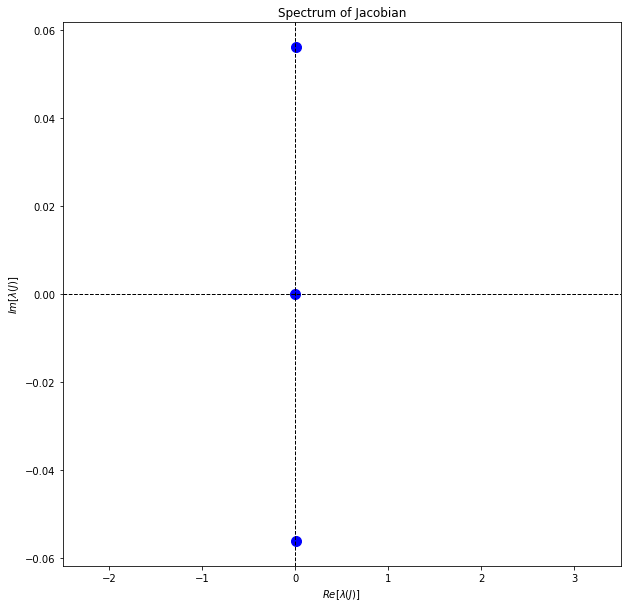

In [179]:
#Plot 

fig, axes = plt.subplots(1, 1, figsize = (10, 10)) 


for x in jacobian_eigs: 
    
    real, im = x.as_real_imag()

    #Plot Learning
    axes.plot(real, im, color = 'blue', marker = 'o', linewidth=1, markersize=10)
    axes.set_title('Spectrum of Jacobian')
    axes.set_xlabel(r'$Re[\lambda(J)]$')
    axes.set_ylabel(r'$Im[\lambda(J)]$')

axes.set_xlim(-2.5,3.5)
#axes.set_ylim(-3,3)
plt.axvline(x=0, linewidth=1, markersize=2, color = 'black', linestyle = "dashed")
plt.axhline(y=0, linewidth=1, markersize=2, color = 'black', linestyle = "dashed")

fig.savefig('./figs/arcRNN_spectrum_alpha{}_gain{}.png'.format(alpha, gain),format='png')

## Compute the Manifold of arcRNN

In [8]:
def f1(h1,h2,h3, J, W, alpha, gain): 
    
    ls = ((2/pi)*atan(W[0,0]*h1 + W[0,1]*h2 + W[0,2]*h3))/(1 + exp(-a*(W[0,0]*h1 + W[0,1]*h2 + W[0,2]*h3)))
    rs = (-h1 + J[0,0]*tanh(g*h1) + J[0,1]*tanh(g*h2) + J[0,2]*tanh(g*h3))
    
    
    return ls*rs

def f2(h1,h2,h3, J, W, alpha, gain): 
    
    ls = ((2/pi)*atan(W[1,0]*h1 + W[1,1]*h2 + W[1,2]*h3))/(1 + exp(-a*(W[1,0]*h1 + W[1,1]*h2 + W[1,2]*h3)))
    rs = (-h2 + J[1,0]*tanh(g*h1) + J[1,1]*tanh(g*h2) + J[1,2]*tanh(g*h3))
    
    return ls*rs

def f3(h1, h2, h3, J, W, alpha, gain): 
    
    ls = ((2/pi)*atan(W[2,0]*h1 + W[2,1]*h2 + W[2,2]*h3))/(1 + exp(-a*(W[2,0]*h1 + W[2,1]*h2 + W[2,2]*h3)))
    rs = (-h2 + J[2,0]*tanh(g*h1) + J[2,1]*tanh(g*h2) + J[2,2]*tanh(g*h3))
    
    return ls*rs

In [112]:
def smooth_surface(points, h1,h2):
    
    def apply_estimator(moneyness, exp, points, h1, h2):
        up_sum = 0
        down_sum = 0
        for p in points:
            gk = gaussian_kernel(moneyness - p[0],exp-p[1],h1,h2)
            up_sum += gk*p[2]
            down_sum += gk
        return up_sum/down_sum
            
    def gaussian_kernel(x,y, h1, h2):
        return (1/2*math.pi)*math.exp((-x**2)/(2*h1))*math.exp((-y**2)/(2*h2))
    
    moneyness = np.linspace(-0.472253,-0.000833,50)
    expiry = np.linspace(-0.92916,0.38404,50)
    surface = []
    
    for i in range(len(moneyness)):
        for j in range(len(expiry)):
            smoothed_point = apply_estimator(moneyness[i],expiry[j],points, h1, h2)
            surface.append([moneyness[i],expiry[j],smoothed_point])
    return np.array(surface)

In [113]:
#load manifold data

gammaRNN_manifold = np.load('./data/gammaRNN_manifold.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')

In [114]:
#put manifold data into array
fixed_points = []

for fixed in gammaRNN_manifold: 
    x,y,z = float(fixed[0][0]), float(fixed[1][0]), float(fixed[2][0])
    
    fixed_points.append(np.array([x,y,z]))

In [115]:
a = np.array(fixed_points)

In [116]:
b = smooth_surface(a,0.01,0.05)

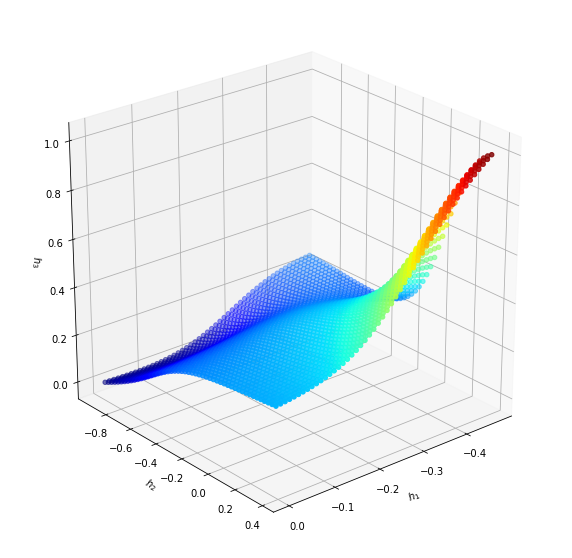

In [143]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')


b[:,2] = (b[:,2]-np.nanmin(b[:,2])) /(np.nanmax(b[:,2]) - np.nanmin(b[:,2]))

ax.scatter(b[:,0], b[:,1], b[:,2], marker='o', cmap='jet',c=b[:,2])

ax.set_xlabel(r'$h_1$')
ax.set_ylabel(r'$h_2$')
ax.set_zlabel(r'$h_3$')


#plt.show()

view = 3
ax.view_init(25,50)
#ax.view_init(10,5)
#ax.view_init(5,-7)

#fig.savefig('./figs/manifold_gammaRNN_view{}.png'.format(view),format='png')